# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

## Setup

In [52]:
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

# modelling
import scipy
import gensim
from gensim.models import ldaseqmodel

# data processing
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sn
%matplotlib inline

# misc
import itertools
import json
import requests
import time

## Data Loading

In [53]:
# load data
congress_abortion_df = pd.read_csv('../data/congress_legislation_cleaned.csv')
congress_abortion_df = congress_abortion_df.loc[:, ['congress_num', 'legislation number', 'title', 'cleaned_summary', 'cleaned_text']]
congress_abortion_df.head()

,congress_num,legislation number,title,cleaned_summary,cleaned_text
0,118,H.R. 2907,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....
1,118,S. 1297,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....
2,118,H.R. 4901,Reproductive Health Care Accessibility Act,Reproductive Health Care Accessibility Act Thi...,Congressional Bills 118th Congress From the U....
3,118,S. 2544,Reproductive Health Care Accessibility Act,Reproductive Health Care Accessibility Act Thi...,Congressional Bills 118th Congress From the U....
4,118,H.R. 4147,Reproductive Health Care Training Act of 2023,NaN,Congressional Bills 118th Congress From the U....


In [54]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()

In [55]:
# count vectorizer
congress_abortion_vects = ngCountVectorizer.fit_transform(congress_abortion_df['cleaned_text'])
print(congress_abortion_vects.shape)

(1243, 47501)


In [56]:
# tfidf
congress_abortion_TFIDFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(congress_abortion_vects)
congress_abortion_TFIDF = congress_abortion_TFIDFTransformer.transform(congress_abortion_vects)

print(congress_abortion_TFIDF.shape)
congress_vocabulary = dict(zip(ngCountVectorizer.vocabulary_.keys(), congress_abortion_TFIDF.data))

(1243, 47501)


In [57]:
#  tfidf vectorizer - limiting the number of tokens
congress_abortion_TFIDFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
congress_abortion_TFIDFVects = congress_abortion_TFIDFVectorizer.fit_transform(congress_abortion_df['cleaned_text'])

## Helper Functions

### Silhouette Analysis

In [58]:
def plotSilhouette(n_clusters, X, reduced_data, pca):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

### Visualization Tools

In [59]:
# get colors
import random

def generate_random_color():
    """
    Generate a random RGB color.
    """
    r = random.uniform(0, 1)
    g = random.uniform(0, 1)
    b = random.uniform(0, 1)
    return (r, g, b)

def generate_random_colors(N):
    """
    Generate a list of random RGB colors.
    """
    colors = []
    for _ in range(N):
        color = generate_random_color()
        colors.append(color)
    return colors

### Dataframe Tools

In [294]:
# get random indices
def random_indices(df_len, num_indices):
    """
    Generate a list of random indices.

    returns: list of random indices
    """
    random_indices = np.random.choice(df_len, num_indices, replace=False)
    random_indices = list(random_indices)
    random_indices.sort()

    return random_indices

### Tokenization

In [134]:
# These helper functions were created by Michael Plunkett (on GitHub, @michplunkett)
normalized_texts = 0
tokenized_texts = 0
num_rows = congress_abortion_df.shape[0]

def split_list(split_text) :
    # Split list into chunks of 1000 words
    step = 1000
    text_lists = []
    for i in range(0, len (split_text), step):
        x = i
        text_lists.append(split_text[x: x + step])
    return text_lists

def tokenize_iter(text):
    start_time = time.time()
    text_lists = split_list(text.split(" "))
    res_set = set()
    for tl in text_lists:
        res_set.update(lucem_illud.word_tokenize(tl))
    
    global tokenized_texts
    tokenized_texts += 1
    print(f"Tokenization took {round (time.time () - start_time, 2)}") 
    print(f" {tokenized_texts} of {num_rows} texts")
    
    return list(res_set)

def normalize_tokens (text_list):
    start_time = time.time()
    text_lists = split_list(text_list)
    res_set = set ()
    for tl in text_lists:
        res_set.update(lucem_illud.normalizeTokens (tl))
    global normalized_texts
    global num_rows
    normalized_texts += 1

    print(f"Normalization took {round(time.time() - start_time, 2)} seconds.")
    print(f" {normalized_texts} of {num_rows} texts normalized.")
    return list(res_set)

In [62]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

## *Exercise 1*

Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

### TF-IDF

In [63]:
# looking up the indices of different words
print(ngCountVectorizer.vocabulary_.get('abortion'))
print(ngCountVectorizer.vocabulary_.get('viable'))
print(ngCountVectorizer.vocabulary_.get('privacy'))

14147
46273
37538


In [64]:
# these words are not very distinctive across our corpus
print(f"Word: abortion, TF-IDF: {congress_vocabulary['abortion']}")
print(f"Word: reproductive, TF-IDF: {congress_vocabulary['reproductive']}")
print(f"Word: viable, TF-IDF: {congress_vocabulary['viable']}")
print(f"Word: privacy, TF-IDF: {congress_vocabulary['privacy']}")

Word: abortion, TF-IDF: 0.04175285176179652
Word: reproductive, TF-IDF: 0.024111711472912006
Word: viable, TF-IDF: 0.03220319273216083
Word: privacy, TF-IDF: 0.018035191774359752


In [65]:
# look at matrix
print(congress_abortion_TFIDFVects.toarray())

[[0.06957559 0.         0.         ... 0.         0.         0.        ]
 [0.06808128 0.         0.         ... 0.         0.         0.        ]
 [0.0601521  0.02014931 0.0055646  ... 0.         0.         0.02294168]
 ...
 [0.0417537  0.         0.00590748 ... 0.         0.0082657  0.        ]
 [0.21651663 0.0106071  0.01041544 ... 0.00981166 0.         0.        ]
 [0.09615914 0.01593029 0.01256982 ... 0.00270655 0.         0.        ]]


In [66]:
# look at vocabulary
congress_abortion_TFIDFVectorizer.vocabulary_

{'ensure': 397,
 'right': 836,
 'reproductive': 807,
 '2023': 67,
 'ms': 616,
 'energy': 391,
 'addition': 118,
 'judiciary': 547,
 'determined': 346,
 'consideration': 276,
 'jurisdiction': 550,
 'provider': 749,
 'employee': 385,
 'physician': 695,
 'certified': 229,
 'assistant': 183,
 'engaged': 394,
 'delivery': 329,
 'authorized': 191,
 'potential': 710,
 'education': 373,
 'counseling': 303,
 'hospital': 488,
 'site': 876,
 'manner': 585,
 '50': 92,
 'district': 363,
 'columbia': 249,
 'unit': 964,
 'local': 573,
 'county': 306,
 'political': 704,
 'prevent': 720,
 'providing': 752,
 'enforcement': 393,
 'attorney': 186,
 'behalf': 203,
 'official': 649,
 'limitation': 566,
 'requirement': 812,
 'court': 307,
 'set': 868,
 'violation': 978,
 'private': 729,
 'affected': 134,
 'relief': 797,
 'staff': 890,
 'award': 194,
 'temporary': 933,
 'permanent': 689,
 'costs': 301,
 'reasonable': 763,
 'fees': 439,
 'non': 627,
 'courts': 308,
 'regard': 783,
 'party': 674,
 'administrati

### PCA

In [67]:
PCA = sklearn.decomposition.PCA
congress_pca = PCA(n_components = 2).fit(congress_abortion_TFIDFVects.toarray())
congress_reduced_data = congress_pca.transform(congress_abortion_TFIDFVects.toarray())

### Identifying the number of clusters

/var/folders/k_/7gvbhq_s1mb10jgw8rq8w4t00000gn/T/ipykernel_13095/1326162309.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


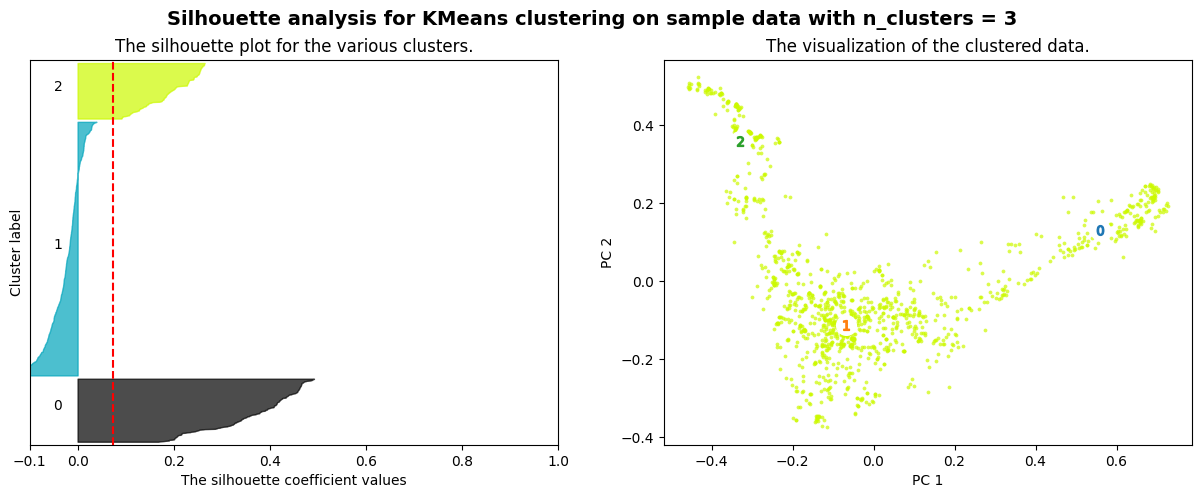

For n_clusters = 3, The average silhouette_score is : 0.073


In [68]:
# k=3
X_congr = congress_abortion_TFIDFVects.toarray()
plotSilhouette(3, X_congr, congress_reduced_data, congress_pca)

/var/folders/k_/7gvbhq_s1mb10jgw8rq8w4t00000gn/T/ipykernel_13095/1326162309.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


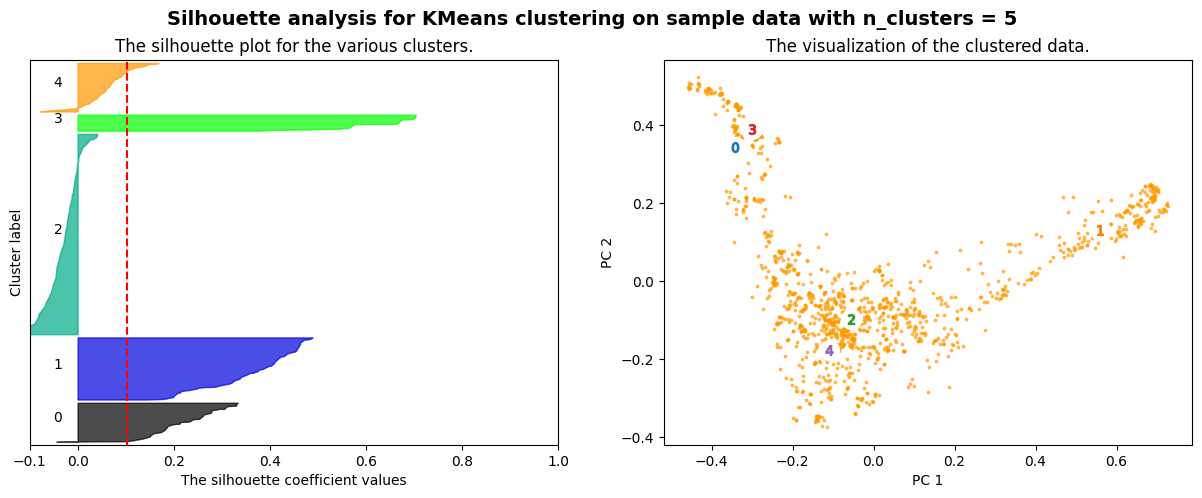

For n_clusters = 5, The average silhouette_score is : 0.103


In [69]:
# k=5
plotSilhouette(5, X_congr, congress_reduced_data, congress_pca)

/var/folders/k_/7gvbhq_s1mb10jgw8rq8w4t00000gn/T/ipykernel_13095/1326162309.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


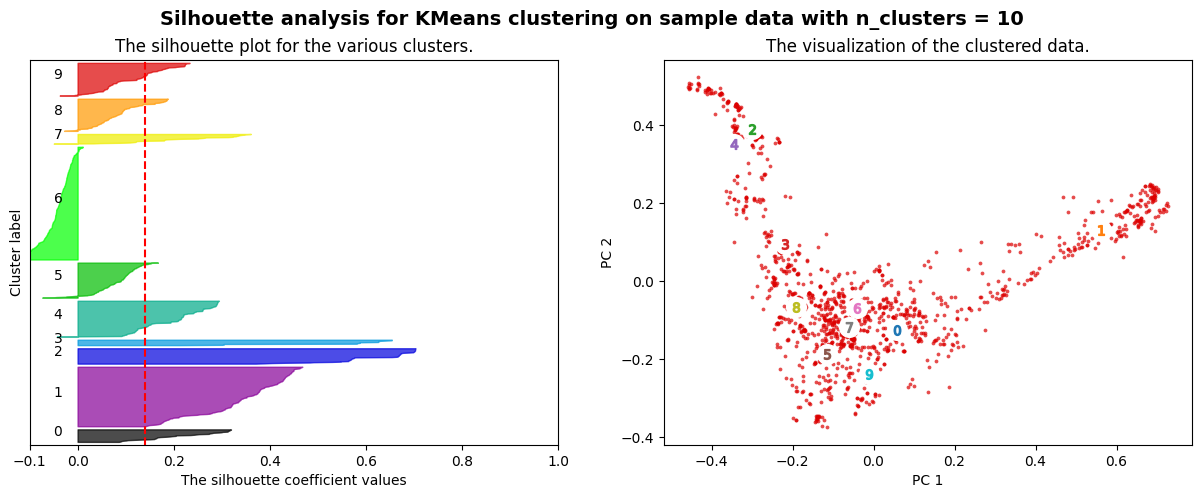

For n_clusters = 10, The average silhouette_score is : 0.140


In [70]:
# k = 10
plotSilhouette(10, X_congr, congress_reduced_data, congress_pca)

/var/folders/k_/7gvbhq_s1mb10jgw8rq8w4t00000gn/T/ipykernel_13095/1326162309.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


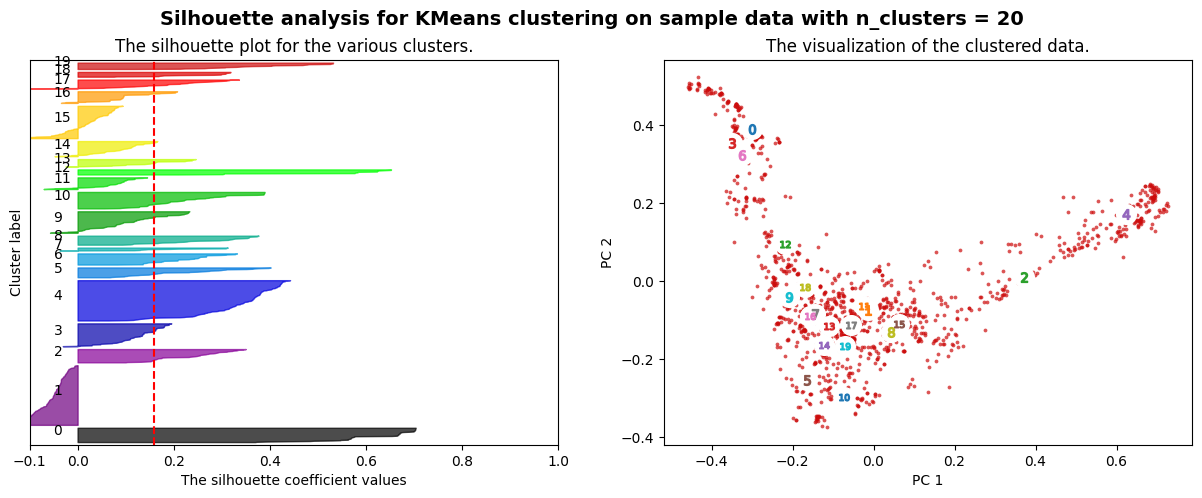

For n_clusters = 20, The average silhouette_score is : 0.159


In [71]:
# k=20
plotSilhouette(20, X_congr, congress_reduced_data, congress_pca)

/var/folders/k_/7gvbhq_s1mb10jgw8rq8w4t00000gn/T/ipykernel_13095/1326162309.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


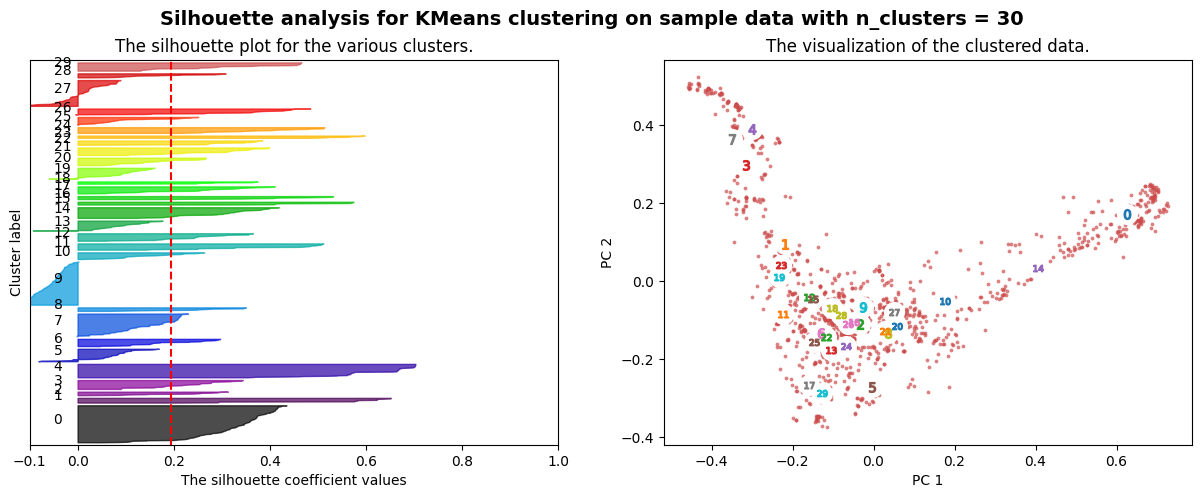

For n_clusters = 30, The average silhouette_score is : 0.195


In [72]:
# k=30
plotSilhouette(30, X_congr, congress_reduced_data, congress_pca)

### Model Building

In [73]:
# initialize a k-means model
numClusters = 30
congress_abortion_KM = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
congress_abortion_KM.fit(congress_abortion_TFIDFVects)

KMeans(n_clusters=30)

In [74]:
rand_indices = random_indices(len(congress_abortion_df), 10)
congress_abortion_df['kmeans_predictions'] = congress_abortion_KM.labels_
congress_abortion_df.loc[rand_indices, ['title', 'kmeans_predictions']]

,title,kmeans_predictions
135,Child Interstate Abortion Notification Act,6
263,Providing for Life Act,10
288,Born-Alive Abortion Survivors Protection Act,23
372,Women Veterans and Families Health Services Ac...,25
453,Child Custody Protection Act of 2015,6
556,Pain-Capable Unborn Child Protection Act,8
657,"Commerce, Justice, Science, and Related Agenci...",2
685,Pregnant Women Support Act,10
1054,Project for American Renewal Act,10
1149,U.S. Health Service Act,15


In [75]:
terms = congress_abortion_TFIDFVectorizer.get_feature_names_out()
abortion_order_centroids = congress_abortion_KM.cluster_centers_.argsort()[:, ::-1]

top_words_by_cluster_df = pd.DataFrame.from_dict({'top_words': [' '.join([terms[ind] for ind in abortion_order_centroids[i, :5]]) for i in range(numClusters)]})
top_words_by_cluster_df

,top_words
0,abortions physician chapter prohibit woman
1,defense department 000 military intelligence
2,000 expenses authorized remain exceed
3,program fiscal security striking medicaid
4,provider woman unborn pregnant consent
5,ms women restrictions access reproductive
6,minor parent requiring notification laws
7,sex selection unborn transition woman
8,unborn woman physician chapter violation
9,china republic people trade president


### Visualization

In [76]:
random_colors = generate_random_colors(numClusters)
congress_random_colors = [random_colors[c] for c in congress_abortion_df['kmeans_predictions']]

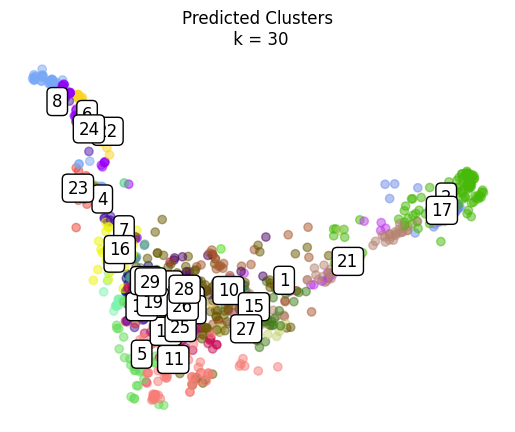

In [77]:
cluster_labels = np.array(congress_abortion_df['kmeans_predictions'])

# Your existing plot code
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(congress_reduced_data[:, 0], congress_reduced_data[:, 1], color=congress_random_colors, alpha=0.5)
plt.xticks(())
plt.yticks(())
plt.title(f'Predicted Clusters\n k = {numClusters}')

# Calculate the centroid of each cluster for labeling
for i in range(numClusters):
    points_in_cluster = congress_reduced_data[cluster_labels == i]
    centroid = points_in_cluster.mean(axis=0)
    plt.annotate(i, (centroid[0], centroid[1]), fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

### Analyzing Cluster Content

#### Top words: unborn woman pregnant physician children
- Intuition: from the titles, it seems that this cluster is for legislation against abortion, specifically in terms of protecting children with disabilities and discussing fetal pain/viability

In [78]:
df = congress_abortion_df.loc[congress_abortion_df.loc[:, 'kmeans_predictions'] == 14, ['legislation number', 'title']].reset_index(drop=True)
rand_indices = random_indices(len(df), 5)
df.loc[rand_indices, :]

,legislation number,title
1,H.R. 128,Defund Planned Parenthood Act of 2023
6,S. 1966,Protecting Life and Taxpayers Act of 2019
7,H.R. 833,Protecting Life and Taxpayers Act of 2019
9,H.R. 853,Protecting Life and Taxpayers Act of 2017
12,H.R. 3134,Defund Planned Parenthood Act of 2015


#### Top words: 000 expenses authorized remain fiscal
- Intuition: this cluster seems primarily concerned with budgets

In [79]:
df = congress_abortion_df.loc[congress_abortion_df.loc[:, 'kmeans_predictions'] == 12, ['legislation number', 'title']].reset_index(drop=True)
rand_indices = random_indices(len(df), 5)
df.loc[rand_indices, :]

,legislation number,title
1,S. 1297,Let Doctors Provide Reproductive Health Care Act
3,S. 2544,Reproductive Health Care Accessibility Act
9,S. 2053,Freedom to Travel for Health Care Act of 2023
15,H.R. 2430,Women’s Healthcare Anti-Death Penalty Construc...
42,H.R. 776,Freedom of Choice Act of 1995


#### Top words: commission trade rules ms enforce
- Intuition: this cluster contains legislation against misinformation in abortion advertising

In [80]:
df = congress_abortion_df.loc[congress_abortion_df.loc[:, 'kmeans_predictions'] == 24, ['legislation number', 'title']].reset_index(drop=True)
rand_indices = random_indices(len(df), 5)
df.loc[rand_indices, :]

,legislation number,title
10,S. 14,Unborn Child Pain Awareness Act of 2010
17,S. 2466,Unborn Child Pain Awareness Act of 2004
20,S. 146,Unborn Victims of Violence Act of 2003
23,S. 480,Unborn Victims of Violence Act of 2001
32,S. 64,Unborn Children's Civil Rights Act


#### Top words: ms women reproductive restrictions access
- Intuition: this cluster contains legislation aimed at protecting abortion as healthcare

In [81]:
df = congress_abortion_df.loc[congress_abortion_df.loc[:, 'kmeans_predictions'] == 27, ['legislation number', 'title']].reset_index(drop=True)
rand_indices = random_indices(len(df), 5)
df.loc[rand_indices, :]

,legislation number,title
2,H.R. 5360,Welfare Reform and Upward Mobility Act
6,H.R. 1135,Welfare Reform Act of 2011
9,S. 834,Real Welfare Reform Act of 1995
10,S. 1956,"Personal Responsibility, Work Opportunity, and..."
14,S. 2134,Welfare Reform Act of 1994


#### Top words: sex selection unborn transition woman
- Intuition: Another cluster regarding legislation preventing aboriton, specifically preventing abortion based on the sex of the fetus.

In [82]:
df = congress_abortion_df.loc[congress_abortion_df.loc[:, 'kmeans_predictions'] == 6, ['legislation number', 'title']].reset_index(drop=True)
rand_indices = random_indices(len(df), 5)
df.loc[rand_indices, :]

,legislation number,title
22,H.R. 634,Child Interstate Abortion Notification Act
26,S. 403,Child Interstate Abortion Notification Act
31,H.R. 1755,Child Custody Protection Act
33,H.R. 476,Child Custody Protection Act
36,S. 3102,Putting Parents First Act


### Reflection
The organization of my clusters shows that there are many domains in which abortion access is dicussed (in terms of insurance, people with disabilities, abortion travel, healthcare, etc.) and that with these domains, there exist arguments for or against abortion access.

## *Exercise 2*

Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)?

***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

### Get random sample

In [83]:
rand_indices = random_indices(len(congress_abortion_df), 100)

### Get co-occurrence matrix

In [84]:
congressCoocMat = congress_abortion_TFIDFVects * congress_abortion_TFIDFVects.T
congressCoocMat.setdiag(0)

### Using Ward Linkage

In [85]:
congress_abortion_TFIDFVects[rand_indices].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01630364, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.30370442, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.02469166, 0.01792057, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01518689, 0.01653339, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.45249506, 0.08739924, 0.00877705, ..., 0.02834827, 0.        ,
         0.        ]])

#### Build linkage matrix
Based on the random sample

In [86]:
# linkage metric using word occurence similarity
congress_linkage_ward = scipy.cluster.hierarchy.ward(congressCoocMat.toarray()[rand_indices, :][:, rand_indices])

/opt/homebrew/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


#### Compute nested clusters

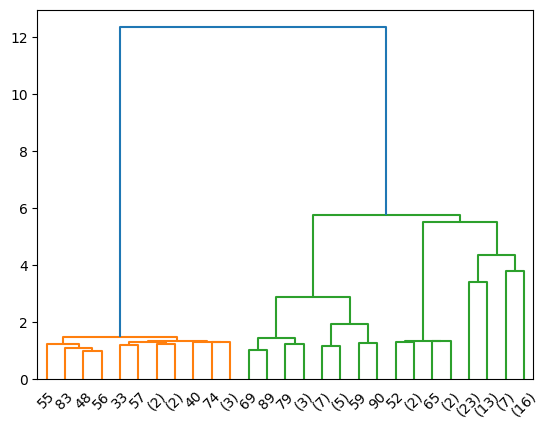

In [87]:
# compute the tree of nested clusters
ax = scipy.cluster.hierarchy.dendrogram(congress_linkage_ward, p=4, truncate_mode='level')

#### Split into clusters
Using the full dataset

In [88]:
# cluster based on linkage matrix - split into 24 clusters (the number of leafs in the dendrogram)
congress_linkage_ward = scipy.cluster.hierarchy.ward(congressCoocMat.toarray())
congress_hierarchicalClusters = scipy.cluster.hierarchy.fcluster(congress_linkage_ward, 24, 'maxclust')

/opt/homebrew/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


#### Evaluate in comparison to kmeans

In [89]:
# evaluate the clusters based on the legislation title
# assumption: legislation title is a good representation of the legislation clusters
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(congress_abortion_df['title'], congress_hierarchicalClusters)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(congress_abortion_df['title'], congress_hierarchicalClusters)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(congress_abortion_df['title'], congress_hierarchicalClusters)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(congress_abortion_df['title'], congress_hierarchicalClusters)))

For our complete clusters:
Homogeneity: 0.452
Completeness: 0.995
V-measure: 0.622
Adjusted Rand Score: 0.040


#### Reflection
Using the walds linkage, in comparison to the kmeans silhouette score of 0.195, I get a completeness score of 0.995 when comparing clusters based on the title of the documents within the cluster, indicating a good level of separation. This indicates that legislation is organized around similar titles, particularly if a given piece of legislation is an updated form of a previous piece. There is a moderate score (0.452) for homogeneity, indicating that clusters may be similarly separated using this method in comparison to the kmeans method (again, if legislation title is our indicator).

#### Append ward predictions

In [90]:
congress_abortion_df['ward_predictions'] = congress_hierarchicalClusters
congress_abortion_df.drop_duplicates(subset=['ward_predictions']).sort_values(by=['ward_predictions'])

,congress_num,legislation number,title,cleaned_summary,cleaned_text,kmeans_predictions,ward_predictions
93,118,H.R. 4366,"Consolidated Appropriations Act, 2024","Consolidated Appropriations Act, 2024 This bil...",Congressional Bills 118th Congress From the U....,2,1
421,115,H.R. 3355,Department of Homeland Security Appropriations...,(This measure has not been amended since it wa...,Congressional Bills 115th Congress From the U....,2,2
117,118,H.R. 2670,National Defense Authorization Act for Fiscal ...,National Defense Authorization Act for Fiscal ...,Congressional Bills 118th Congress From the U....,1,3
671,111,H.R. 3312,"Preventing Unintended Pregnancies, Reducing th...","Preventing Unintended Pregnancies, Reducing th...",Congressional Bills 111th Congress From the U....,10,4
111,118,S. 74,Providing for Life Act of 2023,Providing for Life Act of 2023 This bill revis...,Congressional Bills 118th Congress From the U....,10,5
32,118,H.R. 2573,To express the Sense of Congress with respect ...,This bill expresses the sense of Congress that...,Congressional Bills 118th Congress From the U....,5,6
0,118,H.R. 2907,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....,12,7
85,118,H.R. 398,Protecting Life and Integrity in Research Act ...,Protecting Life and Integrity in Research Act ...,Congressional Bills 118th Congress From the U....,20,8
4,118,H.R. 4147,Reproductive Health Care Training Act of 2023,NaN,Congressional Bills 118th Congress From the U....,10,9
83,118,S.J.Res. 10,A joint resolution providing for congressional...,This joint resolution nullifies the interim fi...,Congressional Bills 118th Congress From the U....,25,10


### Using Complete linkage

#### Build linkage matrix

In [91]:
# linkage metric using word occurence similarity
congress_linkage_complete = scipy.cluster.hierarchy.complete(congressCoocMat.toarray()[rand_indices, :][:, rand_indices])

/opt/homebrew/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:363: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


#### Compute nested clusters

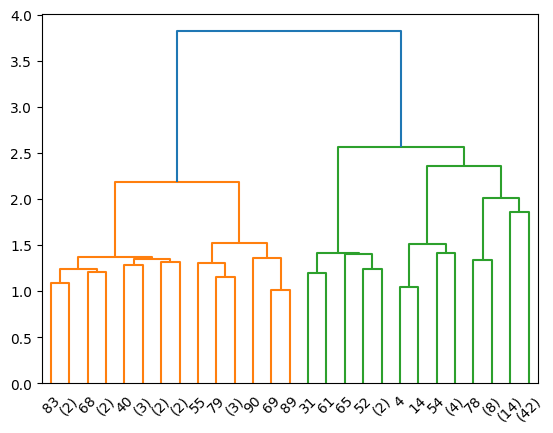

In [92]:
# compute the tree of nested clusters
ax = scipy.cluster.hierarchy.dendrogram(congress_linkage_complete, p=4, truncate_mode='level')

#### Split into clusters
Using the full dataset

In [93]:
# cluster based on linkage matrix - split into 29 clusters (the number of leafs in the dendrogram)
congress_linkage_complete = scipy.cluster.hierarchy.complete(congressCoocMat.toarray())
congress_hierarchicalClusters = scipy.cluster.hierarchy.fcluster(congress_linkage_complete, 29, 'maxclust')

/opt/homebrew/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:363: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


#### Evaluate in comparison to kmeans

In [94]:
# evaluate the clusters based on the kmeans prediction
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(congress_abortion_df['title'], congress_hierarchicalClusters)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(congress_abortion_df['title'], congress_hierarchicalClusters)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(congress_abortion_df['title'], congress_hierarchicalClusters)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(congress_abortion_df['title'], congress_hierarchicalClusters)))

For our complete clusters:
Homogeneity: 0.458
Completeness: 0.993
V-measure: 0.627
Adjusted Rand Score: 0.036


#### Append complete predictions

In [95]:
congress_abortion_df['complete_predictions'] = congress_hierarchicalClusters
congress_abortion_df.drop_duplicates(subset=['complete_predictions']).sort_values(by=['complete_predictions'])

,congress_num,legislation number,title,cleaned_summary,cleaned_text,kmeans_predictions,ward_predictions,complete_predictions
93,118,H.R. 4366,"Consolidated Appropriations Act, 2024","Consolidated Appropriations Act, 2024 This bil...",Congressional Bills 118th Congress From the U....,2,1,1
663,112,H.R. 5882,"Legislative Branch Appropriations Act, 2013","Legislative Branch Appropriations Act, 2013 Ti...",Congressional Bills 112th Congress From the U....,2,2,2
488,114,H.R. 2772,"Department of State, Foreign Operations, and R...",(This measure has not been amended since it wa...,Congressional Bills 114th Congress From the U....,21,3,3
117,118,H.R. 2670,National Defense Authorization Act for Fiscal ...,National Defense Authorization Act for Fiscal ...,Congressional Bills 118th Congress From the U....,1,3,4
9,118,H.R. 7,No Taxpayer Funding for Abortion and Abortion ...,No Taxpayer Funding for Abortion and Abortion ...,Congressional Bills 118th Congress From the U....,11,17,5
225,117,H.R. 6060,Conscience Protection Act of 2021,Conscience Protection Act of 2021 This bill pr...,Congressional Bills 117th Congress From the U....,11,18,6
12,118,H.R. 4303,Abortion Justice Act of 2023,NaN,Congressional Bills 118th Congress From the U....,3,16,7
111,118,S. 74,Providing for Life Act of 2023,Providing for Life Act of 2023 This bill revis...,Congressional Bills 118th Congress From the U....,10,5,8
636,112,H.R. 165,Informed Choice Act,Informed Choice Act Allows the Secretary of He...,Congressional Bills 112th Congress From the U....,10,5,9
254,117,H.R. 3800,GLOBE Act of 2021,Greater Leadership Overseas for the Benefit of...,Congressional Bills 117th Congress From the U....,21,5,10


#### Reflection
Similar to the ward linkage method, the complete method leads to clusters that have a high completeness (0.973) score and a moderate (0.458) homogeneity score. This seems to reiterate the idea that the legislation in my corpus can be adequately clustered based on title. Additionally, when comparing the three clustering methods in the dataframe above, the completeness linkage method does provide finer-grained clustering than the ward method, but kmeans seems to be able to better group legislation that likely has the same topic (i.e., the "Consolidated Appropriations Act, 2024" and the "Legislative Branch Appropriations Act, 2013" having a budgetary topic) but has variations in the titles.

## *Exercise 3*

Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?

### Tokenize text

In [135]:
congress_abortion_df['tokenized_text'] = congress_abortion_df['cleaned_text'].apply(lambda x: tokenize_iter(x))


Tokenization took 0.21
 1 of 1243 texts
Tokenization took 0.2
 2 of 1243 texts
Tokenization took 0.5
 3 of 1243 texts
Tokenization took 0.51
 4 of 1243 texts
Tokenization took 0.13
 5 of 1243 texts
Tokenization took 0.13
 6 of 1243 texts
Tokenization took 0.16
 7 of 1243 texts
Tokenization took 0.12
 8 of 1243 texts
Tokenization took 0.02
 9 of 1243 texts
Tokenization took 0.27
 10 of 1243 texts
Tokenization took 0.24
 11 of 1243 texts
Tokenization took 0.07
 12 of 1243 texts
Tokenization took 0.59
 13 of 1243 texts
Tokenization took 0.18
 14 of 1243 texts
Tokenization took 0.13
 15 of 1243 texts
Tokenization took 0.08
 16 of 1243 texts
Tokenization took 0.08
 17 of 1243 texts
Tokenization took 0.04
 18 of 1243 texts
Tokenization took 0.24
 19 of 1243 texts
Tokenization took 0.25
 20 of 1243 texts
Tokenization took 0.05
 21 of 1243 texts
Tokenization took 0.08
 22 of 1243 texts
Tokenization took 0.07
 23 of 1243 texts
Tokenization took 0.12
 24 of 1243 texts
Tokenization took 0.14
 25 

In [136]:
congress_abortion_df['normalized_tokens'] = congress_abortion_df['tokenized_text'].apply(lambda x: normalize_tokens(x))

/opt/homebrew/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Normalization took 0.07 seconds.
 1 of 1243 texts normalized.
Normalization took 0.06 seconds.
 2 of 1243 texts normalized.
Normalization took 0.09 seconds.
 3 of 1243 texts normalized.
Normalization took 0.08 seconds.
 4 of 1243 texts normalized.
Normalization took 0.04 seconds.
 5 of 1243 texts normalized.
Normalization took 0.04 seconds.
 6 of 1243 texts normalized.
Normalization took 0.06 seconds.
 7 of 1243 texts normalized.
Normalization took 0.05 seconds.
 8 of 1243 texts normalized.
Normalization took 0.01 seconds.
 9 of 1243 texts normalized.
Normalization took 0.07 seconds.
 10 of 1243 texts normalized.
Normalization took 0.06 seconds.
 11 of 1243 texts normalized.
Normalization took 0.03 seconds.
 12 of 1243 texts normalized.
Normalization took 0.15 seconds.
 13 of 1243 texts normalized.
Normalization took 0.05 seconds.
 14 of 1243 texts normalized.
Normalization took 0.04 seconds.
 15 of 1243 texts normalized.
Normalization took 0.02 seconds.
 16 of 1243 texts normalized.
N

### Create corpus

In [137]:
# drop missing words
congress_abortion_df['reduced_tokens'] = congress_abortion_df['normalized_tokens'].apply(lambda x: dropMissing(x, congress_abortion_TFIDFVectorizer.vocabulary_.keys()))

In [138]:
# create dictionary
congress_dictionary = gensim.corpora.Dictionary(congress_abortion_df['reduced_tokens'])

In [139]:
# create corpus
congress_corpus = [congress_dictionary.doc2bow(text) for text in congress_abortion_df['reduced_tokens']]

In [140]:
# serialize the corpus
gensim.corpora.MmCorpus.serialize('congress.mm', congress_corpus)
congressmm = gensim.corpora.MmCorpus('congress.mm')

### Build topic modeling

In [201]:
# lda
congresslda = gensim.models.ldamodel.LdaModel(corpus=congressmm, id2word=congress_dictionary, num_topics=10, alpha='auto', eta='auto')

In [202]:
# inspect a text
congress1Bow = congress_dictionary.doc2bow(congress_abortion_df['reduced_tokens'][0])
congress1lda = congresslda[congress1Bow]
print(f"The topics of the text: {congress_abortion_df['legislation number'][0]} - {congress_abortion_df['title'][0]}")
print("are: {}".format(congress1lda))

The topics of the text: H.R. 2907 - Let Doctors Provide Reproductive Health Care Act
are: [(2, 0.5988793), (8, 0.39355388)]


In [203]:
# save topics
congress_lda_df = pd.DataFrame({
    'legislation_number' : congress_abortion_df['legislation number'],
    'title' : congress_abortion_df['title'],
    'topics' : [congresslda[congress_dictionary.doc2bow(l)] for l in congress_abortion_df['reduced_tokens']]
})

In [217]:
# for subsetting data
rand_indices = random_indices(len(congress_lda_df), 15)

In [219]:
# converting each topic into its own column
#Dict to temporally hold the probabilities
congress_topic_prod_dict = {i : [0] * len(congress_lda_df) for i in range(congresslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(congress_lda_df['topics']):
    for topicNum, prob in topicTuples:
        congress_topic_prod_dict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(congresslda.num_topics):
    congress_lda_df['topic_{}'.format(topicNum)] = congress_topic_prod_dict[topicNum]

congress_lda_df.loc[rand_indices, :]

,legislation_number,title,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
2,H.R. 4901,Reproductive Health Care Accessibility Act,"[(0, 0.5351281), (2, 0.03904476), (3, 0.050840...",0.535128,0.000000,0.039045,0.050841,0.061215,0.000000,0.000000,0.116155,0.194792,0.000000
119,S. 4723,Let Doctors Provide Reproductive Health Care Act,"[(2, 0.6980584), (8, 0.2940867)]",0.000000,0.000000,0.698058,0.000000,0.000000,0.000000,0.000000,0.000000,0.294087,0.000000
163,S. 4354,MARCH for Military Servicemembers Act,"[(3, 0.94376916)]",0.000000,0.000000,0.000000,0.943769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
166,S. 5174,Women's Health Patient Navigator Act of 2022,"[(2, 0.46357656), (8, 0.5263421)]",0.000000,0.000000,0.463577,0.000000,0.000000,0.000000,0.000000,0.000000,0.526342,0.000000
306,H.R. 3563,Stop Shackling and Detaining Pregnant Women Act,"[(2, 0.12200085), (4, 0.57616895), (8, 0.29228...",0.000000,0.000000,0.122001,0.000000,0.576169,0.000000,0.000000,0.000000,0.292282,0.000000
322,H.R. 2082,Parental Notification and Intervention Act of ...,"[(5, 0.9832094)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.983209,0.000000,0.000000,0.000000,0.000000
346,S. 160,Pain-Capable Unborn Child Protection Act,"[(2, 0.79279566), (5, 0.2016983)]",0.000000,0.000000,0.792796,0.000000,0.000000,0.201698,0.000000,0.000000,0.000000,0.000000
383,H.R. 853,Protecting Life and Taxpayers Act of 2017,"[(2, 0.95351744)]",0.000000,0.000000,0.953517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
673,H.R. 1967,To prohibit funding organizations that support...,"[(7, 0.9467229)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.946723,0.000000,0.000000
707,S. 718,Civil Access to Justice Act of 2009,"[(0, 0.111643314), (1, 0.017166045), (2, 0.229...",0.111643,0.017166,0.229204,0.187932,0.156672,0.000000,0.055612,0.070115,0.137414,0.033866


### Visualize topics

In [220]:
ldaDFV = congress_lda_df.loc[rand_indices, :][['topic_%d' %x for x in range(10)]]
ldaDFVisN = congress_lda_df.loc[rand_indices, 'legislation_number']
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
2,0.535128,0.000000,0.039045,0.050841,0.061215,0.000000,0.000000,0.116155,0.194792,0.000000
119,0.000000,0.000000,0.698058,0.000000,0.000000,0.000000,0.000000,0.000000,0.294087,0.000000
163,0.000000,0.000000,0.000000,0.943769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
166,0.000000,0.000000,0.463577,0.000000,0.000000,0.000000,0.000000,0.000000,0.526342,0.000000
306,0.000000,0.000000,0.122001,0.000000,0.576169,0.000000,0.000000,0.000000,0.292282,0.000000
322,0.000000,0.000000,0.000000,0.000000,0.000000,0.983209,0.000000,0.000000,0.000000,0.000000
346,0.000000,0.000000,0.792796,0.000000,0.000000,0.201698,0.000000,0.000000,0.000000,0.000000
383,0.000000,0.000000,0.953517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.946723,0.000000,0.000000
707,0.111643,0.017166,0.229204,0.187932,0.156672,0.000000,0.055612,0.070115,0.137414,0.033866


#### Bar Chart

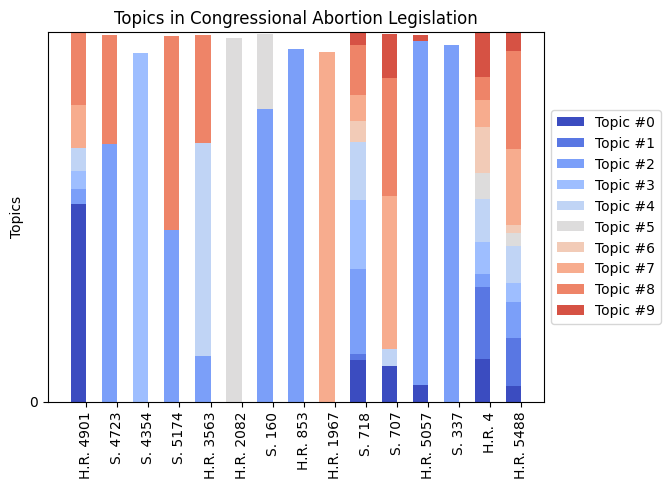

In [221]:
N = 15
ind = np.arange(N)
K = congresslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Congressional Abortion Legislation')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

#### Heat Map

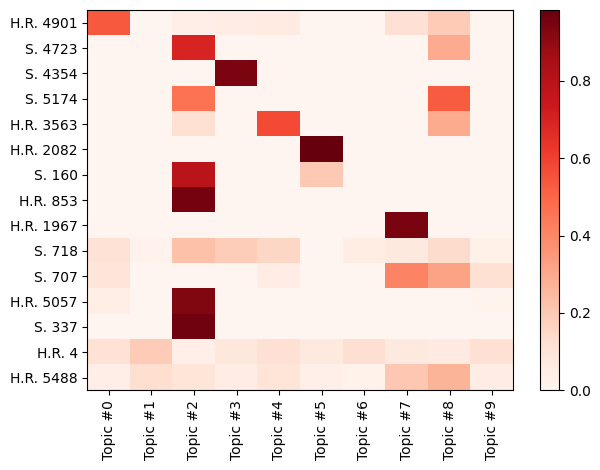

In [222]:
plt.pcolor(ldaDFVis, norm=None, cmap='Reds')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Reds')
plt.tight_layout()  # fixes margins
plt.show()

#### Inspecting topic words

In [223]:
topicsDict = {}
for topicNum in range(congresslda.num_topics):
    topicWords = [w for w, p in congresslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,grant,program,court,days,agency,place,construed,authorized,require,violation
1,sections,laws,relief,striking,notwithstanding,chapter,striking,related,right,amendments
2,receive,construction,woman,given,program,performance,follows,abortions,limitation,consent
3,children,control,physician,later,iv,court,judiciary,treatment,chapter,department
4,effective,paid,costs,authority,terms,development,activities,program,energy,day
5,carry,providing,receive,accordance,given,findings,department,applicable,national,court
6,iv,rule,requirement,non,prior,reasonable,days,established,january,control
7,defined,addition,place,providing,authorization,treatment,prohibit,limitation,appropriated,prevent
8,iii,accordance,laws,access,iii,perform,accordance,seq,conduct,obtain
9,accordance,conduct,condition,related,committees,extent,ensure,education,program,reasonable


In [224]:
congress_abortion_df.loc[congress_abortion_df.loc[:, 'legislation number'].isin(ldaDFVisNames), ['legislation number', 'title']]

,legislation number,title
2,H.R. 4901,Reproductive Health Care Accessibility Act
119,S. 4723,Let Doctors Provide Reproductive Health Care Act
163,S. 4354,MARCH for Military Servicemembers Act
166,S. 5174,Women's Health Patient Navigator Act of 2022
301,S. 707,Reproductive Rights are Human Rights Act of 2019
306,H.R. 3563,Stop Shackling and Detaining Pregnant Women Act
322,H.R. 2082,Parental Notification and Intervention Act of ...
346,S. 160,Pain-Capable Unborn Child Protection Act
383,H.R. 853,Protecting Life and Taxpayers Act of 2017
673,H.R. 1967,To prohibit funding organizations that support...


#### Reflection
Based on the above two visualizations and the correcponsing legislation titles, it seems that those legislations that have fiscal or budgetary concerns span the most topics, which makes sense given the way that budgets are discussed for different organization, including abortion clinics. Topic 2 seems to concern protection legislation of any kind, given by its population of the bills Protecting Life and Taxpayers Act of 2017, Pain-Capable Unborn Child Protection Act, and Let Doctors Provide Reproductive Health Care Act. 

Particularly with the idea of protection, this topic modeling seems to indicate that there are arguments both for and against abortion with a given topic.

### Varying parameters

#### Topics=10, eta=0.00001
- alpha: the number of topics likely to be present
- eta: the number of significant words per topic

In [235]:
# lda
congresslda = gensim.models.ldamodel.LdaModel(corpus=congressmm, id2word=congress_dictionary, num_topics=10, alpha=0.01, eta=0.00001)

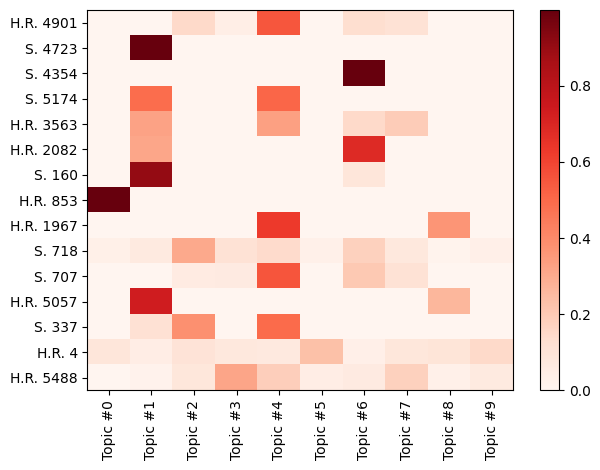

In [236]:
K = congresslda.num_topics  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

congress_lda_df = pd.DataFrame({
    'legislation_number' : congress_abortion_df['legislation number'],
    'title' : congress_abortion_df['title'],
    'topics' : [congresslda[congress_dictionary.doc2bow(l)] for l in congress_abortion_df['reduced_tokens']]
})

congress_topic_prod_dict = {i : [0] * len(congress_lda_df) for i in range(congresslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(congress_lda_df['topics']):
    for topicNum, prob in topicTuples:
        congress_topic_prod_dict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(congresslda.num_topics):
    congress_lda_df['topic_{}'.format(topicNum)] = congress_topic_prod_dict[topicNum]

ldaDFV = congress_lda_df.loc[rand_indices, :][['topic_%d' %x for x in range(10)]]
ldaDFVisN = congress_lda_df.loc[rand_indices, 'legislation_number']
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values

plt.pcolor(ldaDFVis, norm=None, cmap='Reds')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Reds')
plt.tight_layout()  # fixes margins
plt.show()

In [237]:
# inspect topic words
topicsDict = {}
for topicNum in range(congresslda.num_topics):
    topicWords = [w for w, p in congresslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,additional,reasonable,additional,related,program,chapter,department,receive,costs,social
1,given,district,approved,january,authorized,rights,accordance,department,ensure,place
2,construed,court,authority,accordance,seq,district,requirement,directly,notwithstanding,plan
3,days,attorney,laws,manner,conduct,procedures,striking,authorization,chapter,days
4,providing,enforcement,iv,iii,terms,ensure,authorized,conduct,laws,labor
5,prohibit,perform,manner,regulations,et,requirement,determined,laws,columbia,determined
6,making,violation,accordance,prior,provides,table,amendments,program,violation,established
7,non,conduct,columbia,amendments,limitation,pay,effective,relief,table,follows
8,security,findings,number,require,agency,fiscal,chapter,treatment,definition,program
9,energy,development,violation,extent,later,research,defined,national,striking,notwithstanding


In [238]:
congress_abortion_df.loc[congress_abortion_df.loc[:, 'legislation number'].isin(ldaDFVisNames), ['legislation number', 'title']]

,legislation number,title
2,H.R. 4901,Reproductive Health Care Accessibility Act
119,S. 4723,Let Doctors Provide Reproductive Health Care Act
163,S. 4354,MARCH for Military Servicemembers Act
166,S. 5174,Women's Health Patient Navigator Act of 2022
301,S. 707,Reproductive Rights are Human Rights Act of 2019
306,H.R. 3563,Stop Shackling and Detaining Pregnant Women Act
322,H.R. 2082,Parental Notification and Intervention Act of ...
346,S. 160,Pain-Capable Unborn Child Protection Act
383,H.R. 853,Protecting Life and Taxpayers Act of 2017
673,H.R. 1967,To prohibit funding organizations that support...


#### Topics=10, eta=0.9
- alpha: the number of topics likely to be present
- eta: the number of significant words per topic

In [244]:
congresslda = gensim.models.ldamodel.LdaModel(corpus=congressmm, id2word=congress_dictionary, num_topics=20, alpha='auto', eta=0.9)
topicsDict = {}
for topicNum in range(congresslda.num_topics):
    topicWords = [w for w, p in congresslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,related,prohibit,place,rule,striking,fiscal,related,district,conduct,extent,abortions,conduct,directly,court,day,violation,effective,limitation,entities,woman
1,follows,reasonable,condition,manner,cost,program,organization,requirement,support,program,follows,abortions,court,follows,account,later,violation,january,et,abortions
2,place,prevent,injury,later,applicable,iv,grant,right,energy,order,require,amendments,violation,district,agencies,authorized,manner,follows,chapter,treatment
3,determined,chapter,energy,given,laws,payment,activities,determined,effective,local,applicable,authorized,defense,provides,children,injury,clause,authority,social,women
4,age,number,death,days,receive,applicable,program,related,individuals,court,administration,authority,costs,agency,exceed,obtain,providing,place,basis,related
5,authority,accordance,prohibit,order,facilities,administration,private,receive,defined,directly,ensure,administration,control,construction,effective,equal,january,appropriated,access,construed
6,striking,access,chapter,procedures,notwithstanding,seq,work,activities,amendments,construed,requirement,provides,columbia,program,treatment,perform,funding,education,determines,later
7,increase,defined,effective,receive,construed,received,determines,authorized,drug,limitation,program,organization,district,authority,paid,submit,local,striking,later,program
8,control,laws,control,require,department,performance,carry,authority,extent,basis,january,treatment,force,amounts,notification,condition,laws,grant,local,facility
9,costs,obtain,january,regulations,drug,associated,increase,construction,direct,findings,conduct,equal,chapter,right,october,manner,percent,amounts,seq,place


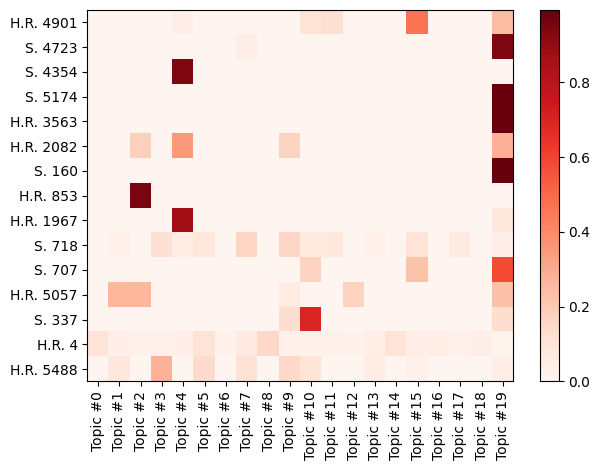

In [245]:
K = congresslda.num_topics  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

congress_lda_df = pd.DataFrame({
    'legislation_number' : congress_abortion_df['legislation number'],
    'title' : congress_abortion_df['title'],
    'topics' : [congresslda[congress_dictionary.doc2bow(l)] for l in congress_abortion_df['reduced_tokens']]
})

congress_topic_prod_dict = {i : [0] * len(congress_lda_df) for i in range(congresslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(congress_lda_df['topics']):
    for topicNum, prob in topicTuples:
        congress_topic_prod_dict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(congresslda.num_topics):
    congress_lda_df['topic_{}'.format(topicNum)] = congress_topic_prod_dict[topicNum]

ldaDFV = congress_lda_df.loc[rand_indices, :][['topic_%d' %x for x in range(K)]]
ldaDFVisN = congress_lda_df.loc[rand_indices, 'legislation_number']
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values

plt.pcolor(ldaDFVis, norm=None, cmap='Reds')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Reds')
plt.tight_layout()  # fixes margins
plt.show()

#### Topics=20, eta=0.0001
- alpha: the number of topics likely to be present
- eta: the number of significant words per topic

In [246]:
congresslda = gensim.models.ldamodel.LdaModel(corpus=congressmm, id2word=congress_dictionary, num_topics=5, alpha='auto', eta=0.00001)
topicsDict = {}
for topicNum in range(congresslda.num_topics):
    topicWords = [w for w, p in congresslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,basis,court,related,perform,violation
1,education,reasonable,require,injury,woman
2,receive,extent,prohibit,conduct,prohibit
3,iii,requirement,activities,order,accordance
4,effective,conduct,department,amendments,control
5,manner,accordance,equal,place,striking
6,women,given,later,security,applicable
7,program,authority,addition,age,perform
8,treatment,prevent,program,death,condition
9,local,procedures,court,iv,making


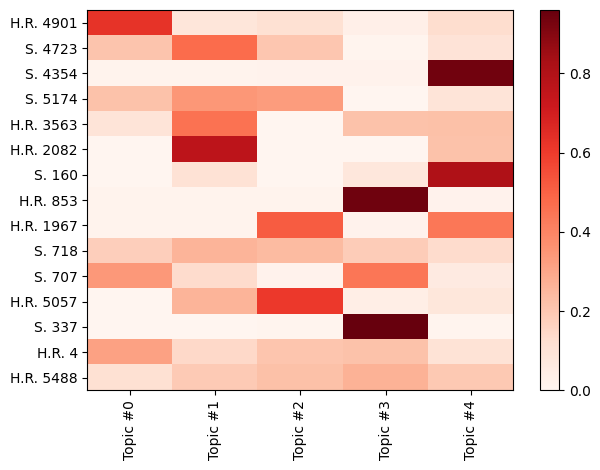

In [247]:
K = congresslda.num_topics  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

congress_lda_df = pd.DataFrame({
    'legislation_number' : congress_abortion_df['legislation number'],
    'title' : congress_abortion_df['title'],
    'topics' : [congresslda[congress_dictionary.doc2bow(l)] for l in congress_abortion_df['reduced_tokens']]
})

congress_topic_prod_dict = {i : [0] * len(congress_lda_df) for i in range(congresslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(congress_lda_df['topics']):
    for topicNum, prob in topicTuples:
        congress_topic_prod_dict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(congresslda.num_topics):
    congress_lda_df['topic_{}'.format(topicNum)] = congress_topic_prod_dict[topicNum]

ldaDFV = congress_lda_df.loc[rand_indices, :][['topic_%d' %x for x in range(K)]]
ldaDFVisN = congress_lda_df.loc[rand_indices, 'legislation_number']
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values

plt.pcolor(ldaDFVis, norm=None, cmap='Reds')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Reds')
plt.tight_layout()  # fixes margins
plt.show()

#### Topics=20, eta=0.9
- alpha: the number of topics likely to be present
- eta: the number of significant words per topic

In [248]:
congresslda = gensim.models.ldamodel.LdaModel(corpus=congressmm, id2word=congress_dictionary, num_topics=5, alpha='auto', eta=0.9)
topicsDict = {}
for topicNum in range(congresslda.num_topics):
    topicWords = [w for w, p in congresslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,given,extent,program,court,january
1,abortions,prohibit,receive,place,control
2,follows,laws,manner,obtain,age
3,conduct,chapter,determined,district,striking
4,authorized,effective,limitation,right,ensure
5,reasonable,directly,iii,laws,construed
6,related,department,authority,authorized,energy
7,providing,findings,pay,rights,laws
8,accordance,providing,requirement,later,consent
9,day,funding,individuals,effective,court


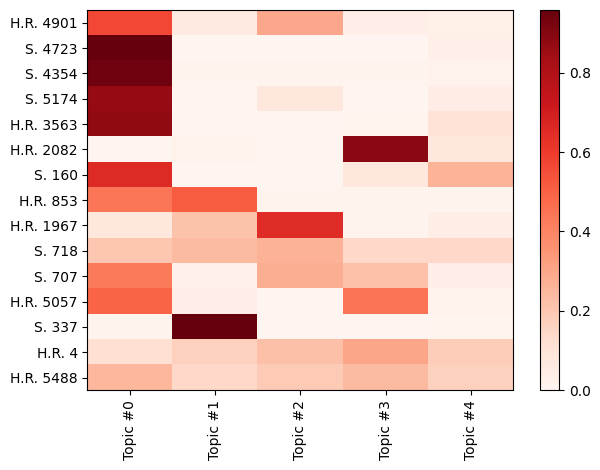

In [249]:
K = congresslda.num_topics  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

congress_lda_df = pd.DataFrame({
    'legislation_number' : congress_abortion_df['legislation number'],
    'title' : congress_abortion_df['title'],
    'topics' : [congresslda[congress_dictionary.doc2bow(l)] for l in congress_abortion_df['reduced_tokens']]
})

congress_topic_prod_dict = {i : [0] * len(congress_lda_df) for i in range(congresslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(congress_lda_df['topics']):
    for topicNum, prob in topicTuples:
        congress_topic_prod_dict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(congresslda.num_topics):
    congress_lda_df['topic_{}'.format(topicNum)] = congress_topic_prod_dict[topicNum]

ldaDFV = congress_lda_df.loc[rand_indices, :][['topic_%d' %x for x in range(K)]]
ldaDFVisN = congress_lda_df.loc[rand_indices, 'legislation_number']
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values

plt.pcolor(ldaDFVis, norm=None, cmap='Reds')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Reds')
plt.tight_layout()  # fixes margins
plt.show()

#### Reflection
Although varying the hyperparameters does produce more or less distinct topical clusters, the documents in my corpus still show significant overlap across topics. This indicates to me that legislation regarding abortion relies on multiple themes to make its argument, including fiscal and budgetary themes, themes of protection, and themes of healthcare access.

## *Exercise 4*

Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

### Visualizing bills over time

In [258]:
congress_bill_count_df = congress_abortion_df.groupby('congress_num', as_index=False).agg({'legislation number': 'count'}).sort_values(by=['congress_num']).rename(columns={'legislation number': 'num_bills'})
congress_bill_count_df

,congress_num,num_bills
0,101,49
1,102,60
2,103,38
3,104,72
4,105,53
5,106,60
6,107,47
7,108,55
8,109,45
9,110,43


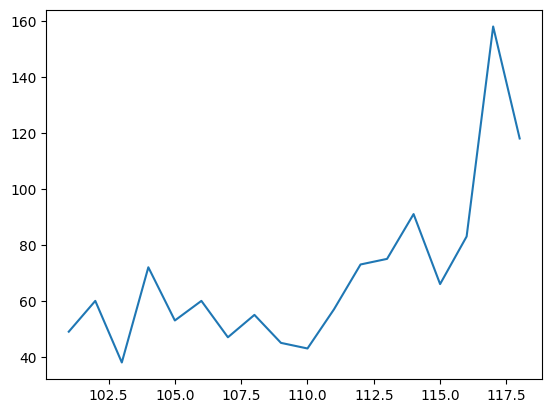

In [259]:
plt.plot(congress_bill_count_df['congress_num'], congress_bill_count_df['num_bills'])

In [292]:
bills_per_congress_slice = [0]*6
def add_docs(congress_num):
    congress_num = int(congress_num)
    if congress_num < 104:
        bills_per_congress_slice[0] += 1
    elif congress_num < 107:
        bills_per_congress_slice[1] += 1
    elif congress_num < 110:
        bills_per_congress_slice[2] += 1
    elif congress_num < 113:
        bills_per_congress_slice[3] += 1
    elif congress_num < 116:
        bills_per_congress_slice[4] += 1
    else:
        bills_per_congress_slice[5] += 1

In [296]:
# subset the data
rand_indices = random_indices(len(congress_abortion_df), 600)
congress_df_subset = congress_abortion_df.loc[rand_indices, :].reset_index(drop=True)

In [297]:
# get counts by congress number
congress_df_subset['congress_num'].apply(lambda x: add_docs(x))

0      None
1      None
2      None
3      None
4      None
       ... 
595    None
596    None
597    None
598    None
599    None
Name: congress_num, Length: 600, dtype: object

In [298]:
bills_per_congress_slice

[78, 89, 66, 85, 104, 178]

In [299]:
# sequentially organize congress corpus
congress_df_subset.sort_values(by=['congress_num'], inplace=True)
congress_df_subset = congress_df_subset.reset_index(drop=True)
congress_df_subset.head()

,congress_num,legislation number,title,cleaned_summary,cleaned_text,kmeans_predictions,ward_predictions,complete_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,101,S. 1671,Family Planning Amendments Act of 1989,Family Planning Amendments Act of 1989 Revises...,S 1671 IS 101st CONGRESS 1st Session S. 1671 T...,3,5,12,"[COMMENT, Health, this, date, OTHER, 1002(b, p...","[date, 1002(b, prepared, certify, amendment, p...","[previously, served, progress, collection, par..."
1,101,H.R. 5114,"Foreign Operations, Export Financing, and Rela...","Foreign Operations, Export Financing, and Rela...",101st CONGRESS 2d Session H. R. 5114 AMENDMENT...,21,3,3,"[unit, this, PRESIDENTIAL, opportunities, Powe...","[unit, opportunities, energy, supplement, 599a...","[unit, energy, primary, value, allocation, pop..."
2,101,S. 1714,United States Commission on Civil Rights Amend...,United States Commission on Civil Rights Amend...,S 1714 IS 101st CONGRESS 1st Session S. 1714 T...,26,13,25,"[equality, this, OTHER, date, amendment, 1975,...","[equality, date, amendment, simon, served, fac...","[served, facilities, terms, carry, established..."
3,101,H.R. 3481,Consumer Seafood Safety Act of 1989,Consumer Seafood Safety Act of 1989 Prohibits:...,HR 3481 IH 101st CONGRESS 1st Session H. R. 34...,3,15,26,"[transport, this, Health, date, prepared, cont...","[transport, date, prepared, energy, contract, ...","[energy, contract, ensure, facilities, country..."
4,101,H.R. 3369,Consumer Seafood Safety Act of 1989,Consumer Seafood Safety Act of 1989 Prohibits:...,HR 3369 IH 101st CONGRESS 1st Session H. R. 33...,3,15,26,"[transport, this, date, prepared, contract, im...","[transport, date, prepared, energy, contract, ...","[energy, contract, ensure, facilities, country..."


In [301]:
# create dictionary
congress_dict_subset = gensim.corpora.Dictionary(congress_df_subset['reduced_tokens'])
congress_corpus_subset = [congress_dict_subset.doc2bow(text) for text in congress_df_subset['reduced_tokens']]


In [306]:
# serialize the corpus
gensim.corpora.MmCorpus.serialize('congress_sub.mm', congress_corpus_subset)
congress_submm = gensim.corpora.MmCorpus('congress_sub.mm')

In [308]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=congress_submm, id2word=congress_dict_subset, time_slice=bills_per_congress_slice, num_topics=10)

/opt/homebrew/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


In [312]:
sorted(ldaseq.print_topics(time=0)[1], key=lambda x: x[0])

[('abortions', 0.006769101312799597),
 ('attorney', 0.0077179786510829995),
 ('children', 0.005990989168032577),
 ('conduct', 0.006873245681163797),
 ('construed', 0.006188063739539039),
 ('court', 0.008037828984907808),
 ('drug', 0.005867339178320367),
 ('judiciary', 0.007509107510902992),
 ('obtain', 0.0061761632738443015),
 ('offense', 0.005495328414418819),
 ('perform', 0.006531534746254591),
 ('physician', 0.0069887720107994974),
 ('pregnant', 0.01073851914894164),
 ('prevent', 0.005506646782816124),
 ('protect', 0.0071846064858559315),
 ('reasonable', 0.007593162499251318),
 ('right', 0.006898231011726467),
 ('unborn', 0.00852179860534525),
 ('violation', 0.008050789785049549),
 ('woman', 0.009848831157404649)]

In [314]:
sorted(ldaseq.print_topics(time=1)[1], key=lambda x: x[0])

[('abortions', 0.0068538342223367155),
 ('attorney', 0.007731635597075197),
 ('children', 0.005885380629627882),
 ('conduct', 0.006942034904420772),
 ('construed', 0.0062315316680188115),
 ('court', 0.008068104732750147),
 ('drug', 0.0059428649773763656),
 ('judiciary', 0.007378901080455536),
 ('obtain', 0.0061675912364919745),
 ('offense', 0.0055435333510690955),
 ('perform', 0.006557637371670988),
 ('physician', 0.0070047753391133),
 ('pregnant', 0.010508818649060274),
 ('protect', 0.007002116212123654),
 ('reasonable', 0.007461897398929407),
 ('right', 0.006749014618795138),
 ('substance', 0.005518948020421759),
 ('unborn', 0.008478298087019779),
 ('violation', 0.008072120264680486),
 ('woman', 0.009849017076793323)]

In [315]:
sorted(ldaseq.print_topics(time=2)[1], key=lambda x: x[0])

[('abortions', 0.006737784375879481),
 ('attorney', 0.0076886158368886385),
 ('children', 0.00568386372606006),
 ('conduct', 0.006967803761819184),
 ('construed', 0.006302125120443202),
 ('court', 0.008109324843263951),
 ('drug', 0.006092462060304836),
 ('judiciary', 0.0071222401755015935),
 ('obtain', 0.00616680798594197),
 ('offense', 0.005585324494917302),
 ('perform', 0.006519036442425634),
 ('physician', 0.0069293527984445324),
 ('pregnant', 0.01018284118081262),
 ('protect', 0.0066881177811709824),
 ('reasonable', 0.007288672252604811),
 ('right', 0.0064995543342279815),
 ('substance', 0.005650319109315063),
 ('unborn', 0.008405251575329543),
 ('violation', 0.00810623021437292),
 ('woman', 0.009809684753055135)]

In [316]:
sorted(ldaseq.print_topics(time=3)[1], key=lambda x: x[0])

[('abortions', 0.006645890981205604),
 ('attorney', 0.00768977212785344),
 ('conduct', 0.006947692278433657),
 ('construed', 0.006375323601617361),
 ('court', 0.008168320073018764),
 ('drug', 0.006287189133832649),
 ('findings', 0.005544213756124109),
 ('judiciary', 0.006865361050539472),
 ('obtain', 0.006197789744769012),
 ('perform', 0.006481371895908604),
 ('physician', 0.006870186574966546),
 ('pregnant', 0.009870119979027894),
 ('protect', 0.006331453489599538),
 ('reasonable', 0.007201285203619069),
 ('requirement', 0.005578005867611835),
 ('right', 0.006227575830451911),
 ('substance', 0.005813333001186978),
 ('unborn', 0.008325682437075703),
 ('violation', 0.008153010956927819),
 ('woman', 0.009757649109492117)]

In [317]:
sorted(ldaseq.print_topics(time=4)[1], key=lambda x: x[0])

[('abortions', 0.006736345074251991),
 ('attorney', 0.00774968513636622),
 ('conduct', 0.007044159029131659),
 ('construed', 0.006481362409991534),
 ('court', 0.008223653609269485),
 ('drug', 0.006463276613995681),
 ('enforcement', 0.005816554735423056),
 ('judiciary', 0.006848678473593589),
 ('obtain', 0.006241436159136916),
 ('perform', 0.006460771033967406),
 ('physician', 0.006959507473777686),
 ('pregnant', 0.009692651687505147),
 ('protect', 0.006043756403500564),
 ('reasonable', 0.007287946403371698),
 ('requirement', 0.005670923410050283),
 ('right', 0.005989394883591649),
 ('substance', 0.00594644775042723),
 ('unborn', 0.008337682388401097),
 ('violation', 0.00819523163780989),
 ('woman', 0.009705275618712749)]

In [313]:
sorted(ldaseq.print_topics(time=5)[1], key=lambda x: x[0])

[('abortions', 0.006785362770902148),
 ('attorney', 0.007794113791673089),
 ('conduct', 0.0070860869871125515),
 ('construed', 0.006575377012526107),
 ('court', 0.00825889463047755),
 ('drug', 0.006642919872854751),
 ('enforcement', 0.006041153511071523),
 ('judiciary', 0.006925170446709938),
 ('obtain', 0.006274223117487402),
 ('perform', 0.006382889935533047),
 ('physician', 0.00700802555782675),
 ('pregnant', 0.009640983855953942),
 ('protect', 0.005864130178044266),
 ('reasonable', 0.007358005046222815),
 ('requirement', 0.005828440995860579),
 ('right', 0.00585498804362546),
 ('substance', 0.006063374314619871),
 ('unborn', 0.008346388176476198),
 ('violation', 0.008219256166486869),
 ('woman', 0.00967179678547935)]

### Reflection
Key differences in topics across congresses:
- A decreased emphasis on the word 'protect' in legislation
- Increased emphasis on 'drug'
- no mention of 'offense' after the second section of congresses